# HGCAL FE studies

### imports and initial setup

In [1]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal

from time import sleep
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly as py

from descartes import PolygonPatch
from tqdm import tqdm_notebook

import scripts.helpers as hlp
from skhep.modeling import bayesian_blocks

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 16})

#%connect_info

/home/naodell/work/hgcal


### Convert data from root ntuples to dataframes

In [2]:
infile = open('data/mc_mixtures/qcd_pt15to7000_skim_test/output_0.pkl', 'rb')
#infile = open('data/mc_mixtures/single_electron_pt15_pu200_skim_test/output_0.pkl', 'rb')
threshold = pickle.load(infile)
gen = pickle.load(infile)
data = pickle.load(infile)

features = ['zside', 'layer', 'sector', 'panel', 'cell', 'subdet',
            'x', 'y', 'z', 
            'pt', 'reco_e', 'sim_e']


### Visualizations of detector hits, panels, and occupancies

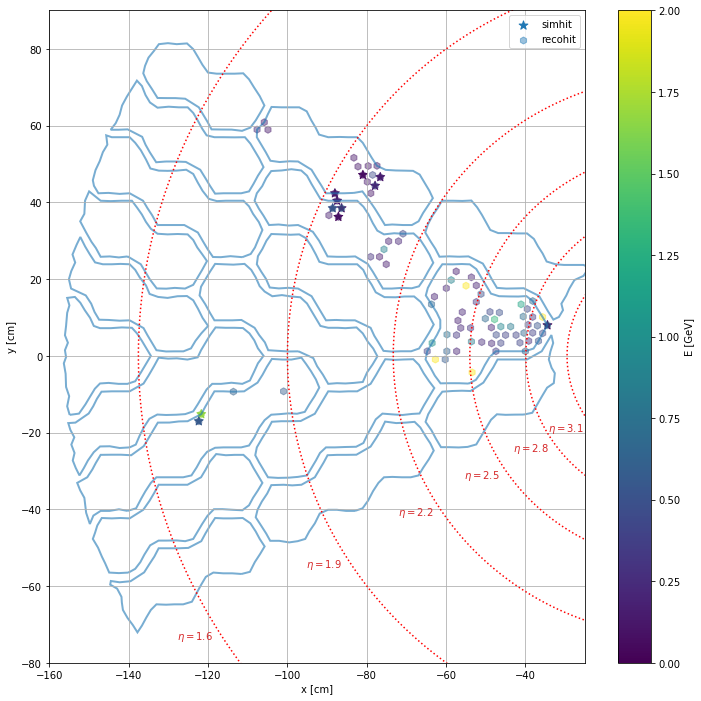

In [3]:
# get patches for module layouts
layer = 7
sector = 1
panel = 4
df = data[8].query('sig_evt')[features]
patch_file = open(f'data/panel_patches_zplus_{layer}.pkl', 'rb')
patches = pickle.load(patch_file)
patch_file.close()

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')
for p, ashape in patches[sector].items():
    col = 'C0'
    patch = PolygonPatch(ashape, fill=False, ec=col, linestyle='-', linewidth=2, label='_nolegend_', alpha=0.6)
    ax.add_patch(patch)

df_skim = df.query(f'subdet == 3 and zside == 1 and sector == 1 and layer == {layer}')
mask = df_skim.sim_e > 0

sim_scat  = ax.scatter(df_skim[mask].x, df_skim[mask].y, c=df_skim.sim_e[mask], 
                       cmap='viridis', 
                       marker='*', 
                       vmin=0.,
                       vmax=2.,
                       s=85, 
                       alpha=1.
                      )
reco_scat = ax.scatter(df_skim.x, df_skim.y, c=df_skim.reco_e, 
                       cmap='viridis', 
                       marker='h', 
                       vmin=0.,
                       vmax=2.,
                       s=50, 
                       alpha=0.45
                      )

ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
#ax.set_facecolor('white')

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

cbar_reco = plt.colorbar(reco_scat, ax=ax, label='E [GeV]')
cbar_reco.set_alpha(1)
cbar_reco.draw_all()

#cbar_sim = plt.colorbar(sim_scat, ax=ax, label=r'$E_{sim}$')
plt.legend(['simhit', 'recohit'])
plt.grid()

plt.savefig('plots/hits_test.png')
plt.show()

In [4]:
# sample occupancy plot
layer = 7
df = pd.concat(data)
df = df.query('sig_evt == False')
df['count'] = np.ones(df.shape[0])
df_avg = df.groupby(['layer', 'panel']).sum()/(7*2*6*len(data)) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
s_panel = df_avg.query(f'layer == {layer}')['count']
s_panel = s_panel.loc[layer]

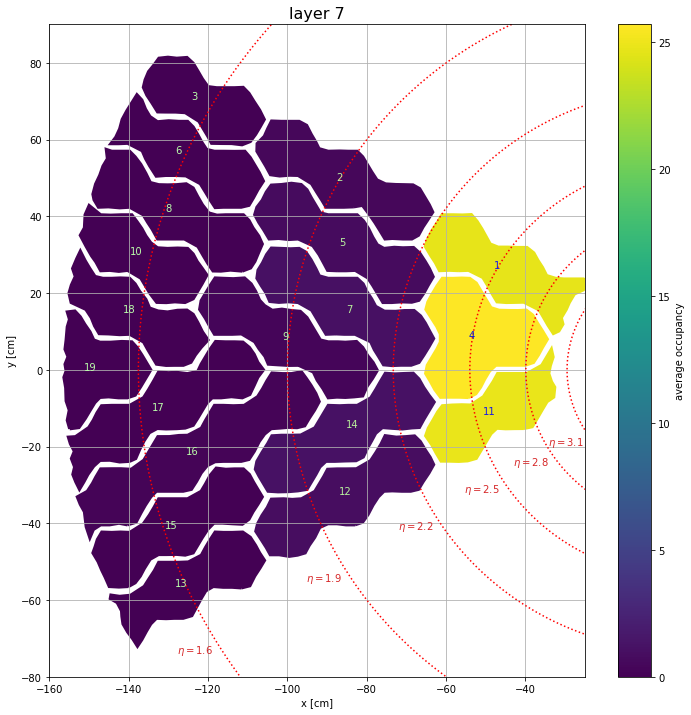

In [5]:
# tmp hack
centers = [( -45.996555,  26.552443), ( -85.601143,  49.418068), (-122.204628,  70.561249),
           ( -52.309528,   8.186293), ( -85.023285,  32.505623), (-126.216042,  56.438793),
           ( -83.052231,  14.980803), (-128.726608,  41.261883), ( -99.199333,   7.929051),
           (-137.761444,  30.080639), ( -48.818104, -11.489166), ( -84.926186, -32.474018),
           (-126.202728, -56.422054), ( -83.127579, -14.974498), (-128.724808, -41.280033),
           (-123.665054, -21.916286), (-132.247528, -10.519128), (-139.554230,  14.877615),
           (-149.350327,  -0.036200)
          ]

def invert_ctuple(ctuple):
    return [1 - c for c in ctuple[:-1]] + [1.]

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')

for p, ashape in patches[sector].items():
    if p not in s_panel.index:
        col = plt.cm.viridis(0)
    else:
        col = plt.cm.viridis(s_panel.loc[p]/s_panel.max())
    patch  = PolygonPatch(ashape, fc=col, fill=True, ec=col, linestyle='-', linewidth=3, label='_nolegend_', alpha=1)
    extent = patch.get_extents().bounds
    ax.add_patch(patch)
    
    c = centers[p-1]
    ax.text(c[0]-2, c[1], f'{p}', color=invert_ctuple(col))
    
ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title(f'layer {layer}')
#ax.set_facecolor('white')

dummy = plt.scatter([0, 0], [0, 0], cmap='viridis', c=[0, s_panel.max()])
cbar = plt.colorbar(dummy, ax=ax, label='average occupancy')
cbar.set_alpha(1)
cbar.draw_all()

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

plt.grid()
#plt.savefig('plots/panel_numbering_test.png')
plt.savefig('plots/panel_occupancy_test.pdf')
plt.show()

In [6]:
# sample occupancy plot
g = df.groupby(['layer', 'wafer', 'cell']) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
df_avg = g.sum()/(7*6*len(data)) # sum_hits/(n_bx*n_sides*n_sectors*n_epochs)
s_cell = df_avg.loc[layer]['count']

cell_map = pd.read_pickle('data/cell_map.pkl')
cell_map = cell_map.loc[1, layer]
cell_map.head(10)

tc_x       tc_y
tc_wafer tc_cell                      
7        0       -36.285336  17.616495
         1       -33.811337  17.616495
         2       -31.337330  17.616497
         3       -28.904566  17.545078
         4       -35.048336  19.759043
         5       -32.574333  19.759043
         6       -30.182800  19.759043
         7       -27.626333  19.759043
         8       -33.811337  21.901588
         9       -31.262360  21.901588

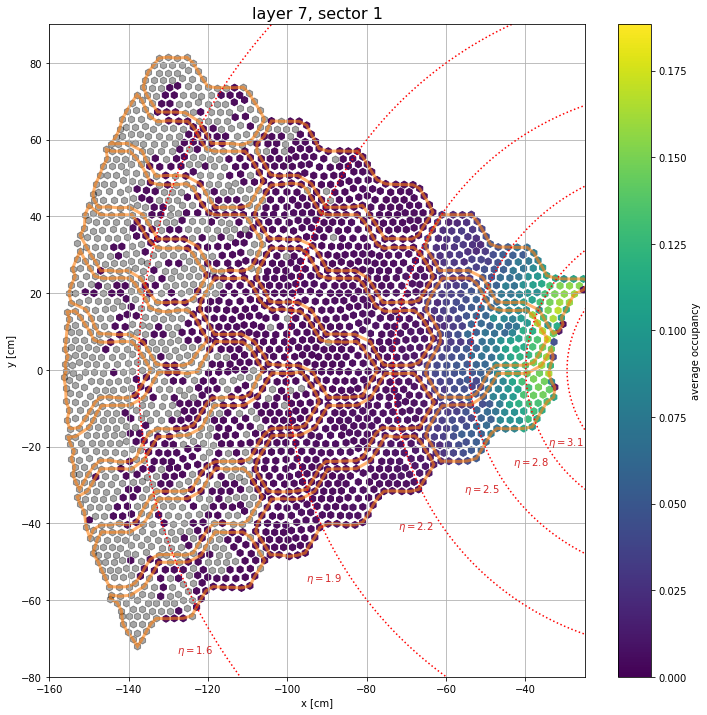

In [7]:
# by cell occupancies

fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='white')

for p, ashape in patches[sector].items():
    patch = PolygonPatch(ashape, fc=col, fill=False, ec='C1', linestyle='-', linewidth=3, label='_nolegend_', alpha=0.6)
    extent = patch.get_extents().bounds
    ax.add_patch(patch)
    
ax.set_ylim(-80, 90)
ax.set_xlim(-160, -25)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title('layer 7, sector 1')
#ax.set_facecolor('white')

#scat = ax.scatter(s_cell.x.values, s_cell.y.values, c=s_cell['count'].values,
test = pd.concat([s_cell, cell_map], axis=1)
test = test.fillna(0) 
x, y, counts = test.tc_x.values, test.tc_y.values, test['count'].values
mask = counts > 0
scat = ax.scatter(x[mask], y[mask], c=counts[mask],
                  cmap='viridis', 
                  marker='h', 
                  vmin=0.,
                  #vmax=2.,
                  s=50, 
                  alpha=0.95
                 )
_ = ax.scatter(x[np.invert(mask)], y[np.invert(mask)], c='k',
               marker='h', 
               vmin=0.,
               #vmax=2.,
               s=50, 
               alpha=0.35
              )


#dummy = plt.scatter([0, 0], [0, 0], cmap='viridis', c=[0, s_cell.max()])
cbar = plt.colorbar(scat, ax=ax, label='average occupancy')
cbar.set_alpha(1)
cbar.draw_all()

# draw some concentric circles
eta   = np.arange(1.6, 3.2, 0.3)
theta = 2*np.arctan(np.exp(-eta))
r     = df_skim.iloc[0].z*np.tan(theta) 
phi   = np.linspace(np.pi/2, 3*np.pi/2, 1000)
xcoord, ycoord  = np.outer(r, np.cos(phi)), np.outer(r, np.sin(phi)) 

for i, (x, y) in enumerate(zip(xcoord, ycoord)):
    ax.plot(x, y, 'r:', label='_nolegend_')
    phi_pos = 7*np.pi/6
    ax.text((r[i] + 10)*np.cos(phi_pos), (r[i] + 10)*np.sin(phi_pos), r'$\eta={0:.1f}$'.format(eta[i]), color='C3', fontsize=10)

plt.grid()
#plt.savefig('plots/panel_numbering_test.png')
plt.savefig('plots/cell_occupancy.png')
plt.show()